### Implementation of your own block matching algorithm for stereo depth reconstruction. 


You are not allowed to use cv2.matchTemplate, cv2.stereoBM or similar functions from opencv or other pre-existing libraries

1. Implement a function that takes two equal size images and calculates the sum of absolute differences. The two equal-sized images are nose_left.png (used as the template) and nose_right.png.

2. Using the function you just created, find which of the three images nose1.png, nose2.png, nose3.png gives the best match to nose_left.png?

3. Since these images are rectified, we can approximately assume that a pixel found in row x in the left image also lives in row x in the right image. nose_span.png contains the entire row containing the nose of the sculpture. The height of the span is 7 - the same height as your template. Write a function that loops through the image from left to right and computes the correlation using your function from step 1 to find where in the span the nose is located.


In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.gray()

<Figure size 432x288 with 0 Axes>

## Initial images

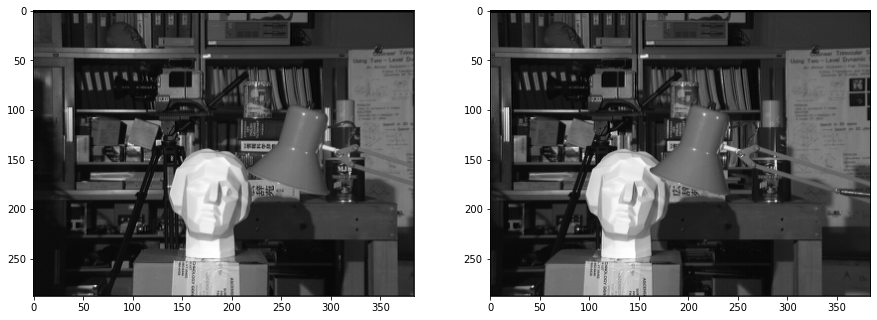

In [2]:
img_left = cv2.imread("tsukuba_left.png")
img_right = cv2.imread("tsukuba_right.png")

img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)

img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
gray_right= cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(gray_left)
axarr[1].imshow(gray_right)

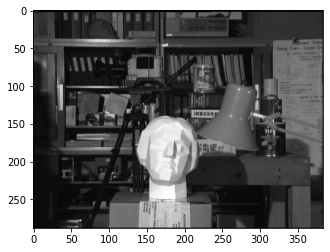

In [3]:
plt.imshow(gray_left)

## Noses

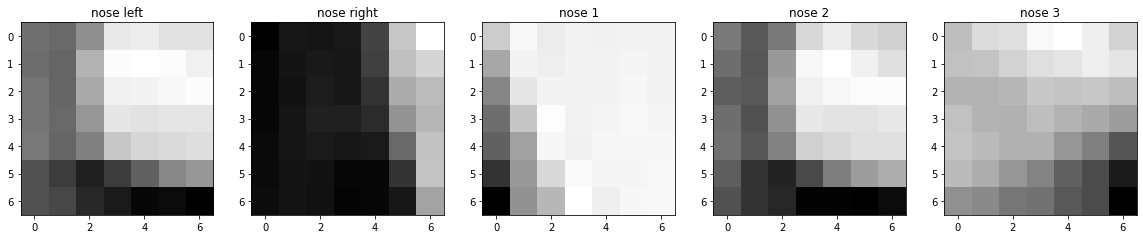

In [4]:
nose_left = cv2.imread("nose_left.png")
nose_right = cv2.imread("nose_right.png")
noses = [cv2.imread("nose1.png"), cv2.imread("nose2.png"), cv2.imread("nose3.png")]

nose_left = cv2.cvtColor(nose_left, cv2.COLOR_BGR2RGB)
nose_left_gray = cv2.cvtColor(nose_left, cv2.COLOR_RGB2GRAY)

nose_right = cv2.cvtColor(nose_right, cv2.COLOR_BGR2RGB)
nose_right_gray= cv2.cvtColor(nose_right, cv2.COLOR_RGB2GRAY)

noses_gray = []
for i, nose in enumerate(noses):
    nose = cv2.cvtColor(nose, cv2.COLOR_BGR2RGB)
    noses_gray.append(cv2.cvtColor(nose, cv2.COLOR_RGB2GRAY))
    
f, axarr = plt.subplots(1,5, figsize = (20,20))
axarr[0].imshow(nose_left_gray)
axarr[0].set_title("nose left")
axarr[1].imshow(nose_right_gray)
axarr[1].set_title("nose right")
for i, nose in enumerate(noses_gray):
    axarr[2+i].imshow(nose)
    axarr[2+i].set_title(f"nose {i+1}")
    

## Absolute differences

Correlation  7657


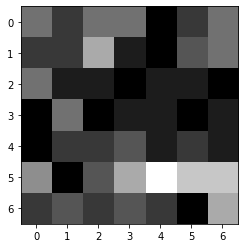

In [5]:
def correlation(img1, img2):
    return np.sum(cv2.absdiff(img1, img2))

# plt.imshow(absoluteDifference(nose_left_gray, noses_gray[1]))
plt.imshow(cv2.absdiff(nose_left_gray, noses_gray[1]))
print("Correlation ", correlation(nose_left_gray, nose_right_gray))

## Best match for nose left

In [6]:
diff = [correlation(nose_left_gray, nose) for nose in noses_gray]
print(f"Best matching image: nose {np.argmin(diff)+1}")

Best matching image: nose 2


## Span best correlation

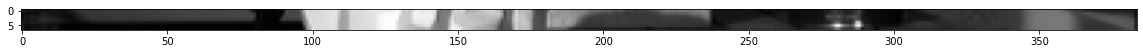

In [7]:
nose_span = cv2.imread("nose_span.png")

nose_span = cv2.cvtColor(nose_span, cv2.COLOR_BGR2RGB)
nose_span_gray = cv2.cvtColor(nose_span, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(20,100))
plt.imshow(nose_span_gray)

In [8]:
kernel_size =  len(nose_left_gray[0]), len(nose_left_gray)
span_size = len(nose_span_gray[0]), len(nose_span_gray),
print(f"kernel size is {kernel_size}")
print(f"span size is {span_size}")

kernel size is (7, 7)
span size is (384, 7)


132


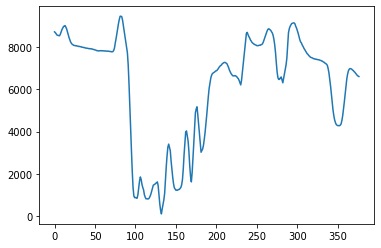

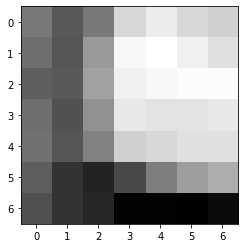

In [9]:
corr = [correlation(nose_left_gray, nose_span_gray[:,i:(i+kernel_size[0])]) for i in range(span_size[0]-kernel_size[0])]

plt.figure()
plt.plot(corr)
idx = np.argmin(corr)
print(idx)

found_nose = nose_span_gray[:, idx:idx+kernel_size[0]]

plt.figure()
plt.imshow(found_nose)

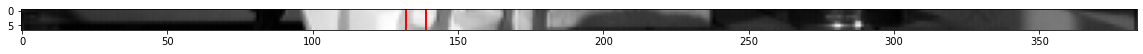

In [10]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, figsize=(20, 100))
ax.imshow(nose_span_gray)
ax.add_patch(Rectangle((idx, -1), kernel_size[0], kernel_size[1]+1, linewidth=2, fill=False, edgecolor='r'))

In [42]:
idx = []
val = []
disparity = []
search_size = 20
for i in range(0, gray_left.shape[0] - kernel_size[0]):
    span = gray_left[i:i+kernel_size[0], :]
    span_size = span.shape
    row_idx = []
    row_val = []
    row_disparity = []
    for j in range(0, gray_left.shape[1] - kernel_size[1] - search_size):
        kernel = gray_right[i:i+kernel_size[0], j:j+kernel_size[1]]
        if(j < search_size):
            search_range = range(j, j+2*search_size)
        else:
            search_range = range(j-search_size, j+search_size)

        corr = [correlation(kernel, span[:,k:k+kernel_size[0]]) for k in search_range] #range(span_size[1]-kernel_size[0])
        minarg = np.argmin(corr)
        row_val.append(corr[minarg])
        if(j>search_size):
            minarg = minarg - search_size + j

        row_idx.append(minarg)
        row_disparity.append(np.abs(j - minarg))

    idx.append(row_idx)
    val.append(row_val)
    disparity.append(row_disparity)

idx = np.array(idx)
val = np.array(val)
disparity = np.array(disparity)

In [20]:
j

369

In [12]:
span_size

(7, 384)

idx.shape  (281, 357)
val.shape  (281, 357)
[[  0   0  21 ... 364 365 366]
 [  0   0  21 ... 364 365 366]
 [  0   0  21 ... 360 365 366]
 ...
 [  0  23  19 ... 372 369 370]
 [  0  23  23 ... 372 374 375]
 [  0  23  19 ... 340 341 341]]
[[ 52  95 137 ...  30  29  27]
 [ 63 115 162 ...  38  37  33]
 [ 73 133 184 ...  43  43  39]
 ...
 [ 82  50  44 ... 168 216 260]
 [ 78  47  41 ... 278 344 406]
 [ 76  50  44 ... 414 497 574]]
[[ 0  1 19 ... 10 10 10]
 [ 0  1 19 ... 10 10 10]
 [ 0  1 19 ...  6 10 10]
 ...
 [ 0 22 17 ... 18 14 14]
 [ 0 22 21 ... 18 19 19]
 [ 0 22 17 ... 14 14 15]]


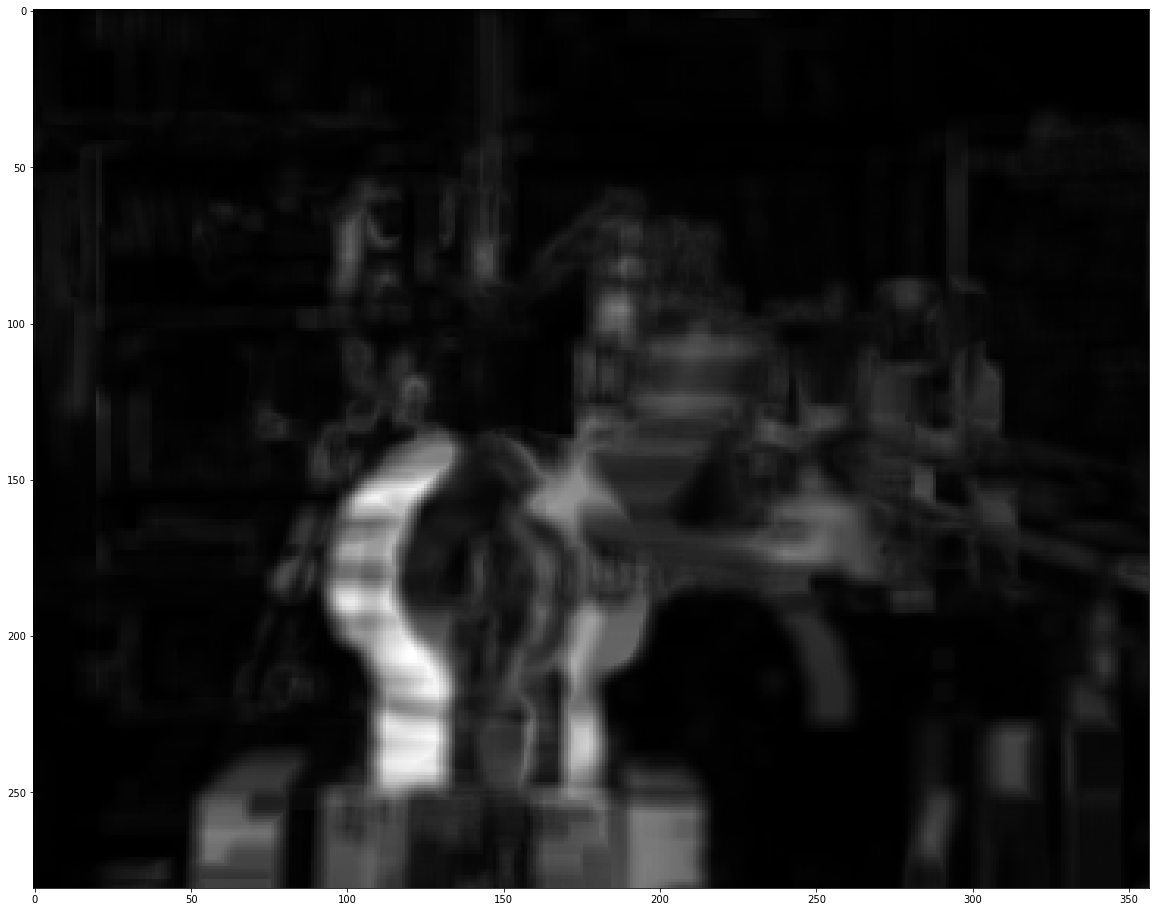

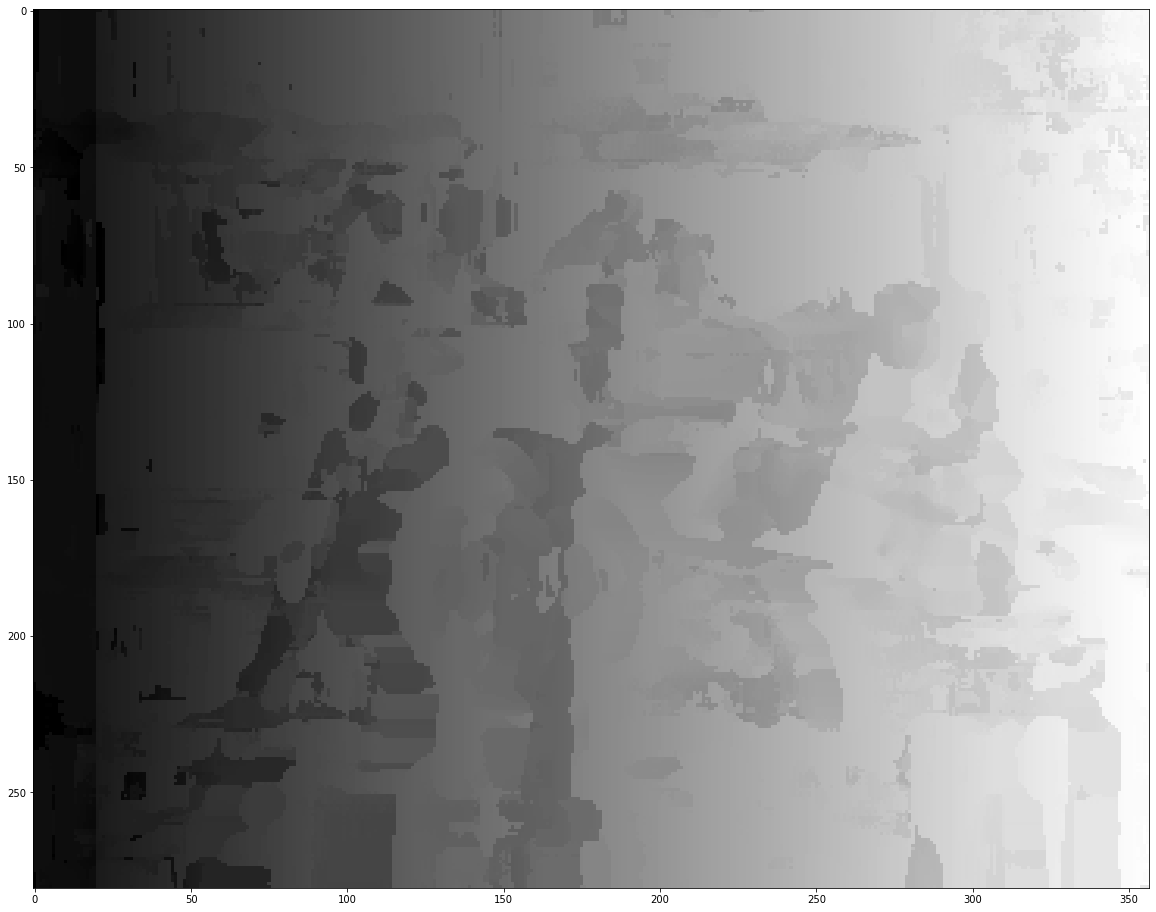

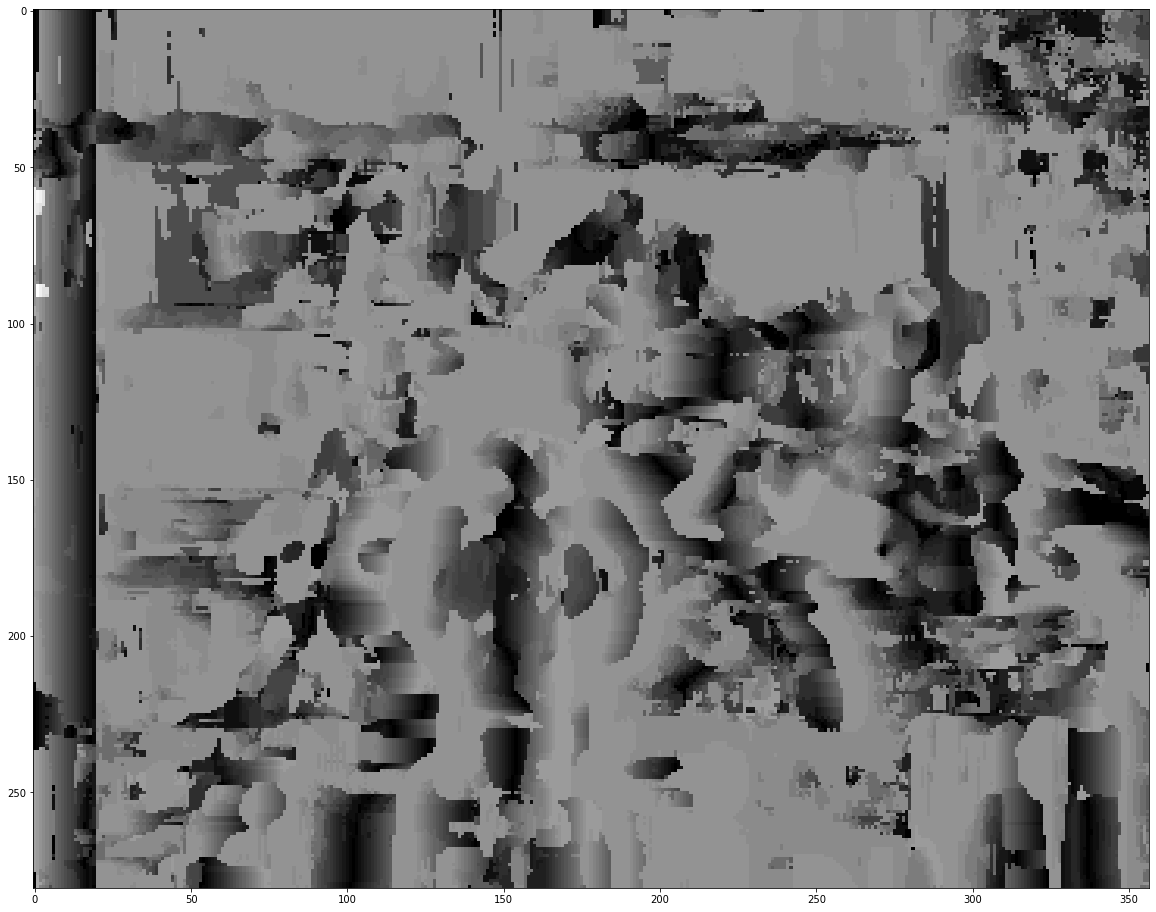

In [43]:
print("idx.shape ", idx.shape)
print("val.shape ", val.shape)
print(idx)
print(val)
print(disparity)
plt.figure(figsize=(20,20))
plt.imshow(val)
plt.figure(figsize=(20,20))
plt.imshow(idx)
plt.figure(figsize=(20,20))
plt.imshow(disparity)